In [4]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [5]:
# Load the datasets
training_data = pd.read_csv(os.path.join('data','DIWBB_Training.csv'))
test_data = pd.read_csv(os.path.join('data','DIWBB_Test.csv'))

C:\Users\pawan\AppData\Local\Temp\ipykernel_36544\1834711055.py:2: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  training_data = pd.read_csv(os.path.join('data','DIWBB_Training.csv'))


In [19]:
placeholders = ['(UNK)', '(N/A)', 'NaN', 'nan', '']
training_data.replace(placeholders, pd.NA, inplace=True)
training_data.replace(placeholders, pd.NA, inplace=True)

In [20]:
# Fill missing values
for column in training_data.columns:
    if training_data[column].dtype == 'object':
        training_data[column].fillna('Unknown', inplace=True)
        if column in test_data.columns:
            test_data[column].fillna('Unknown', inplace=True)
    else:
        median_value = training_data[column].median()
        training_data[column].fillna(median_value, inplace=True)
        if column in test_data.columns:
            test_data[column].fillna(median_value, inplace=True)

In [7]:
# Encode categorical variables and handle unseen categories in test data
categorical_columns = [col for col in training_data.columns if training_data[col].dtype == 'object' and col not in ['ActivityType', 'RecordID']]
for column in categorical_columns:
    le = LabelEncoder()
    training_data[column] = le.fit_transform(training_data[column].astype(str))
    test_data[column] = test_data[column].map(lambda s: s if s in le.classes_ else 'Unknown')
    le.classes_ = np.append(le.classes_, 'Unknown')
    test_data[column] = le.transform(test_data[column])

In [8]:
# Encode the target variable
le_activity = LabelEncoder()
training_data['ActivityType'] = le_activity.fit_transform(training_data['ActivityType'])

In [9]:
# Prepare the feature matrix and target vector
X = training_data.drop(['RecordID', 'ActivityType'], axis=1)
y = training_data['ActivityType']

In [10]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

# Initialize and train the XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [11]:
# Predict on the training set and test set
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

In [12]:
# Calculate accuracy on the training set and test set
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.9950238612542928
Testing Accuracy: 0.9887225949500162


In [13]:
from sklearn.metrics import precision_score, recall_score
 
# Calculate precision and recall on the test set
precision = precision_score(y_test, test_predictions, average='macro') # 'macro' for unweighted mean per class
recall = recall_score(y_test, test_predictions, average='macro') # 'macro' for unweighted mean per class
 
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.6384830024501361
Recall: 0.5467961833287686


In [14]:
from sklearn.model_selection import cross_val_score
 
# Perform 5-fold cross-validation and calculate the average accuracy
cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
 
# Calculate the mean and standard deviation of the cross-validation scores
cv_accuracy_mean = cv_scores.mean()
cv_accuracy_std = cv_scores.std()

In [15]:
print(f"CV Accuracy Mean: {cv_accuracy_mean}")
print(f"CV Accuracy Std: {cv_accuracy_std}")

CV Accuracy Mean: 0.9888276179360007
CV Accuracy Std: 0.0006827629980911584


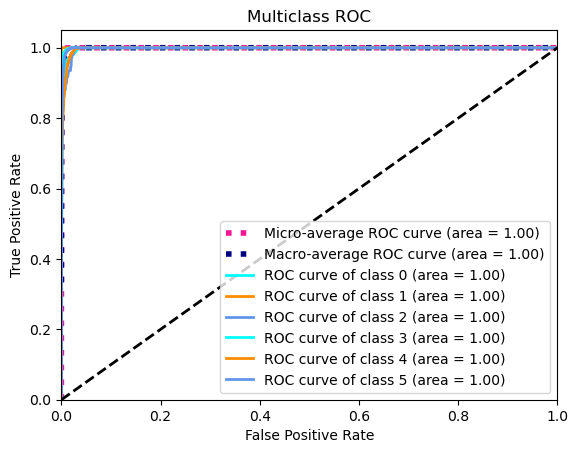

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
 
# Assuming y and your model's predictions are already defined
# Binarize the output labels for multiclass
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]
 
# Compute the model's probabilities for each class
y_score = model.predict_proba(X)
 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
# Compute macro-average ROC curve and ROC area
# First, aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
 
# Finally, average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
 
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Print AUC for each class with five decimal places
for i in range(n_classes):
    print(f"Class {i} AUC: {roc_auc[i]:.5f}")
 
# Print micro-average AUC with five decimal places
print(f"Micro-average AUC: {roc_auc['micro']:.5f}")
 
# Print macro-average AUC with five decimal places
print(f"Macro-average AUC: {roc_auc['macro']:.5f}")

Class 0 AUC: 0.99803
Class 1 AUC: 1.00000
Class 2 AUC: 0.99771
Class 3 AUC: 0.99976
Class 4 AUC: 0.99769
Class 5 AUC: 0.99896
Micro-average AUC: 0.99996
Macro-average AUC: 0.99869


In [10]:
# Prepare the submission for the original test dataset
original_test_predictions = model.predict(test_data.drop(['RecordID'], axis=1))
original_test_predictions_labels = le_activity.inverse_transform(original_test_predictions)

In [11]:
# Prepare the submission DataFrame
submission = pd.DataFrame({
    'RecordID': test_data['RecordID'],
    'ActivityType': original_test_predictions_labels
})

In [12]:
# Save the submission file
submission_filepath = 'DIWBB_Submission_Final_Adjusted.csv'
submission.to_csv(submission_filepath, index=False)

submission_filepath

'DIWBB_Submission_Final_Adjusted.csv'